In [2]:
import random
import cv2 as cv
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [2]:
data_dir = '/kaggle/input/rice-4-class/RiceLeaf_Latest_4class'

In [3]:

IMAGE_SIZE = 300
BATCH_SIZE = 16
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
print(class_names)


Found 4072 files belonging to 4 classes.
['BACTERIAL BLIGHT', 'BLAST', 'BROWNSPOT', 'TUNGRO']


In [4]:
((4072/16)*0.8)

203.60000000000002

In [5]:
(4072/16)*0.1

25.450000000000003

In [6]:
print(f'Total length of dataset: {len(dataset)}')
train_size = 0.8
print(f'Train dataset size: {205}')
train_ds = dataset.take(205)
test_ds = dataset.skip(205)
print(f'Test dataset size: {len(test_ds)}')
val_size = 0.1
# print(len(dataset)*val_size)
val_ds = test_ds.take(25)
print(f'Val dataset size: {len(val_ds)}')
test_ds = test_ds.skip(25)
print(f'Test dataset size: {len(test_ds)}')

Total length of dataset: 255
Train dataset size: 205
Test dataset size: 50
Val dataset size: 25
Test dataset size: 25


In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size =25
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [9]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
epochs = 150

In [10]:
model1 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
model1.build(input_shape=input_shape)
model1.summary()
# Assuming you have 'model' defined from the previous code
# Replace 'model.png' with your desired output file name
# plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 300, 300, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (16, 300, 300, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 298, 298, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 149, 149, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 149, 149, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 74, 74, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 74, 74, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 37, 37, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 37, 37, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 18, 18, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (16, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (16, 9, 9, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (16, 9, 9, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (16, 4, 4, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (16, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (16, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (16, 2, 2, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (16, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,380 (958.52 KB)

 Trainable params: 245,380 (958.52 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [13]:
history1 = model1.fit(
    train_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.2702 - loss: 1.3773 - val_accuracy: 0.5500 - val_loss: 1.0314
Epoch 2/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5439 - loss: 0.9537 - val_accuracy: 0.6675 - val_loss: 0.7136
Epoch 3/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6184 - loss: 0.8049 - val_accuracy: 0.7075 - val_loss: 0.6922
Epoch 4/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6671 - loss: 0.7143 - val_accuracy: 0.6475 - val_loss: 0.7280
Epoch 5/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6610 - loss: 0.7147 - val_accuracy: 0.7525 - val_loss: 0.5695
Epoch 6/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7224 - loss: 0.5917 - val_accuracy: 0.7900 - val_loss: 0.4929
Epoch 7/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7696 - loss: 0.5503 - val_accuracy: 0.8100 - val_loss: 0.4458
Epoch 8/150
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7825 - loss: 

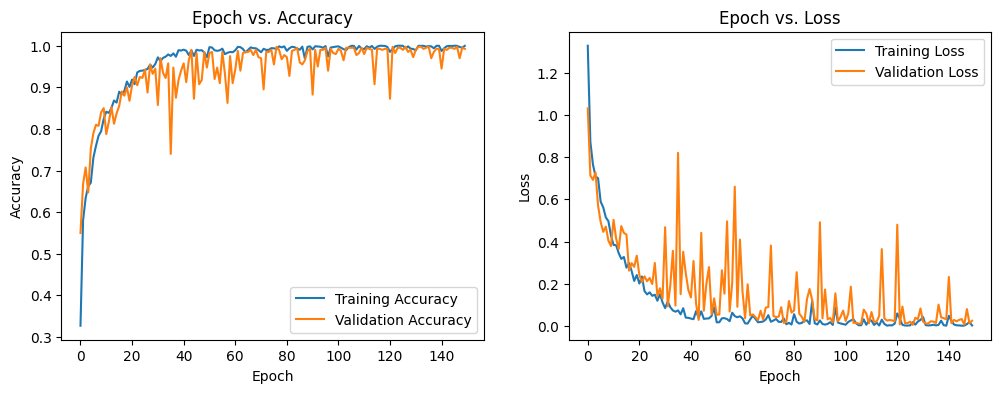

In [14]:

#Plot epoch vs Accuracy and epoch vs Loss
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('epoch_accuracy_loss.png')

plt.show()

In [15]:
scores1 = model1.evaluate(test_ds)
print(scores1)
acc = history1.history['accuracy']
print(acc)
val_acc = history1.history['val_accuracy']
print(val_acc)
loss = history1.history['loss']
print(loss)
val_loss = history1.history['val_loss']
print(val_loss)

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9952 - loss: 0.0142
[0.02864304557442665, 0.9879807829856873]
[0.32708844542503357, 0.5804668068885803, 0.6342137455940247, 0.6624692678451538, 0.6707616448402405, 0.7312653660774231, 0.7592137455940247, 0.7834766507148743, 0.7945331931114197, 0.8243243098258972, 0.8415233492851257, 0.8384521007537842, 0.8507370948791504, 0.8682432174682617, 0.8633292317390442, 0.8894348740577698, 0.8826781511306763, 0.8912776708602905, 0.914004921913147, 0.9011056423187256, 0.9186117649078369, 0.9075552821159363, 0.9358108043670654, 0.9394963383674622, 0.9401105642318726, 0.9419533014297485, 0.9441031813621521, 0.9545454382896423, 0.9474815726280212, 0.9560810923576355, 0.9720516204833984, 0.962837815284729, 0.9708231091499329, 0.9735872149467468, 0.9791154861450195, 0.9754299521446228, 0.9815725088119507, 0.9735872149467468, 0.9892506003379822, 0.9883292317390442, 0.9904791116714478, 0.9880220890045166, 0.9775798320770264, 0.9886363744735718, 0.9

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

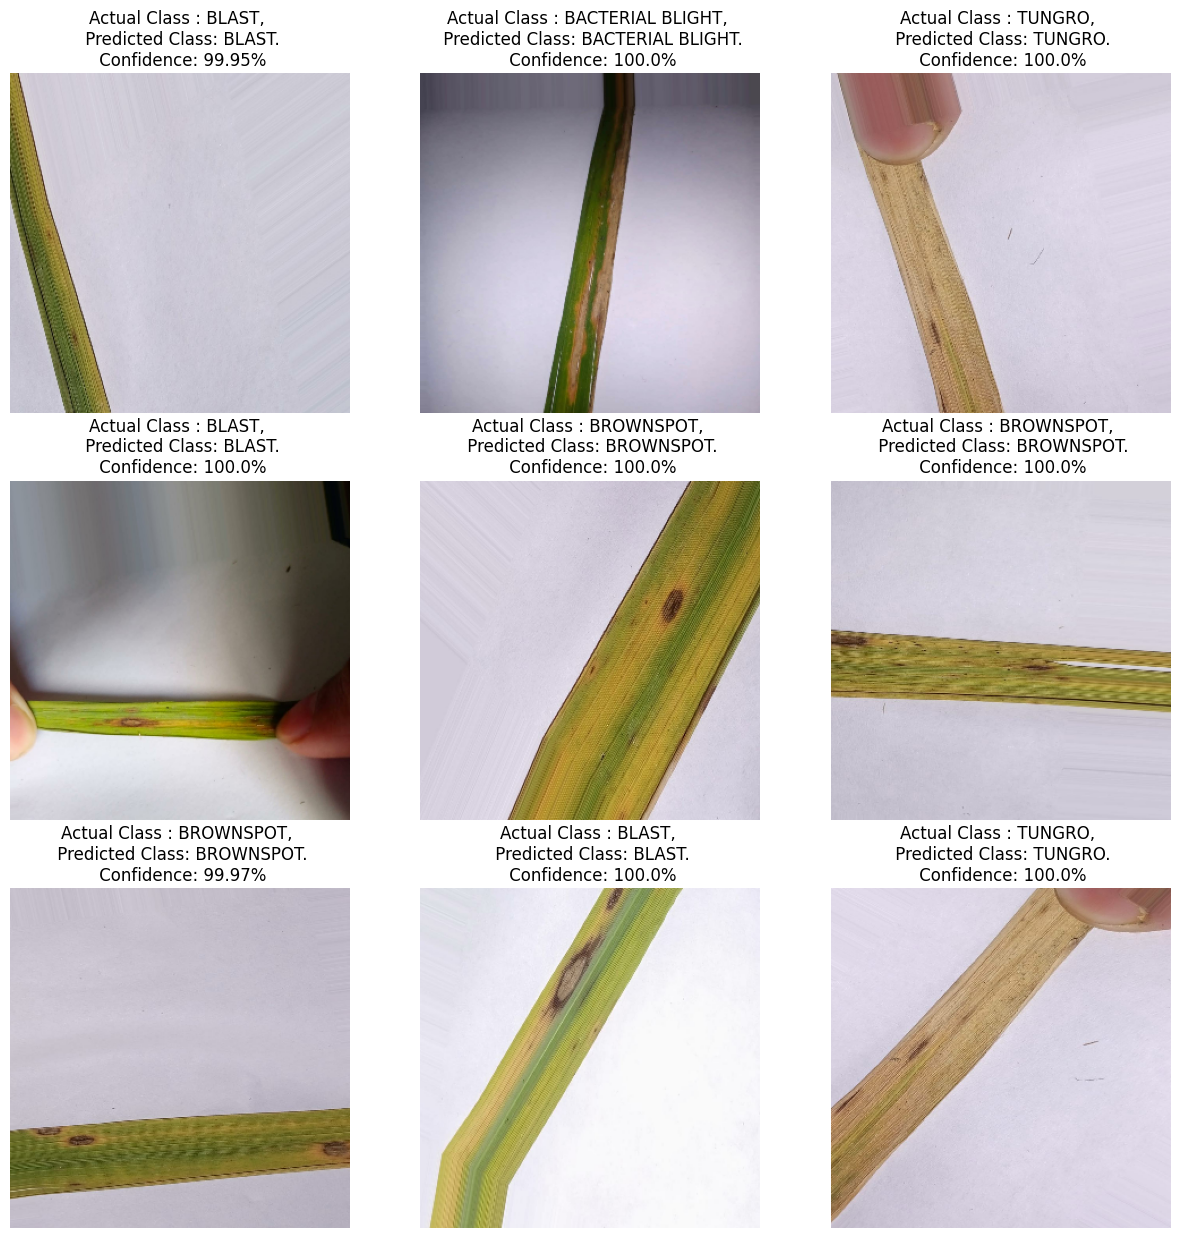

In [18]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model1, images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class : {actual_class}, \n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        plt.savefig('output.png')

        plt.axis("off")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
  y_true.append(label_batch)
  preds = model1.predict(image_batch)
  y_pred.append(np.argmax(preds, axis=-1))

correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
conf_matrix = confusion_matrix(correct_labels, predicted_labels)

In [ ]:
print(classification_report( correct_labels, predicted_labels))

In [ ]:

conf_mat = confusion_matrix(correct_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('CONF.png')

plt.show()


In [ ]:
print("Mean Absolute Error:" , mean_absolute_error(correct_labels,predicted_labels))
print("Mean Squared Error:" , mean_squared_error(correct_labels,predicted_labels))

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# Define your class names
class_names = ['BACTERIAL BLIGHT', 'BLAST', 'BROWNSPOT','TUNGRO']

# Create a dictionary to map numerical labels to class names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Your code for ROC curve
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

# Assuming correct_labels and predicted_labels are defined
y_test_b = label_binarize(correct_labels, classes=np.unique(correct_labels))
predicted_labels_b = label_binarize(predicted_labels, classes=np.unique(predicted_labels))
classes = np.unique(correct_labels)
n_class = classes.shape[0]

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_b[:, i], predicted_labels_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], linestyle='--', label=' %s (AUC = %0.2f)' % (label_to_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.savefig('ROC.png')

plt.show()
